(sec-deustch)=
# The Deutsch problem

We are going to solve a kind of classification problem discussed originally by Deutsch {cite}`Deutsch1985`.   The problem itself is rather trivial and not really useful. However, it demonstrates an advantage of quantum computation over classical computation.

## The problem

Consider a binary function $x \mapsto f(x)$ where $x \in \{0,1\}$ and $f(x)  \in \{0,1\}$. There are only four possible functions, $f_1,\, f_2,\, f_3,\, f_4$.

<table>
    <thead>
        <th><i>x</i></th><th><i>f</i><sub>1</sub></th><th><i>f</i><sub>2</sub></th><th><i>f</i><sub>3</sub></th><th><i>f</i><sub>4</sub></th>
    </thead>
    <tr>
        <td>0</td><td>0</td><td>1</td><td>0</td><td>1</td>
    </tr>
    <tr>
        <td>1</td><td>0</td><td>1</td><td>1</td><td>0</td>
    </tr>
</table>

An oracle possess one of these functions.  We can ask it questions like "what is the value of $f(1)$?"  To find what function it has, we need to ask two questions, "what are $f(0)$ and $f(1)$?".  Now, let us try a simpler problem.  The outputs of $f_1$ and $f_2$ are always the same regardless of the input values.  So, we call them *constant* function.  On the other hand, the outputs of $f_3$ and $f_4$ contain both $0$ and $1$.  We shall call them *balanced* function.  Now, our task is to determine which type of the functions the oracle possess, constant or balanced. Hence, this is a classification task. Only we need to find out is if $f(0)=f(1)$ or $f(0)\ne f(1)$.  How many questions do we need to ask?  Although we don't have to identify the function, it seems that we still need to ask two questions. It turns out that the Deutsch's quantum algorithm requires only one question.

## Encoding the functions

Before solving the problem, we need to find out how to express a function using gates.  Every gate is a unitary operator and thus the operation is reversible.  While $f_3$ and $f_4$ are bijective (invertible), $f_1$ and $f_2$ are even not surjective  and thus not invertible.  Here we use a two-qubit gate $U_f$ acting on $|q_0\rangle \otimes |q_1\rangle$ as defined by

$$
U_f |x\rangle \otimes  |y\rangle = |x\rangle \otimes |y \oplus f(x)\rangle
$$

where $\oplus$ is modulo-2 addition.  The qubit $q_0$ contains the value of $x$ and its value is not affected by the gate.  The second qubit $q_1$ is transformed from $y$ to $y \otimes f(x)$.  When $y=0$, the output is simply the function value $f(x)$.  When $y=1$, $1 \oplus f(x) = 1 - f(x)$.   By knowing the value of $y$ and $y \oplus f(x)$, we can find $f(x)$. 

Does such a gate exist?  If the gate is invertible, we can construct a unitary operator. Noting that $z \oplus z = 0$ for any $z$, 

$$
U_f |x\rangle \otimes |y \oplus f(x)\rangle = |x\rangle \otimes |y \oplus f(x) \oplus f(x)\rangle = |x\rangle \otimes |y \rangle
$$

indicating that $U_f^{-1} = U_f$.  We just make it sure that $U_f$ is self-adjoint.  Here we show the actual gates:


---

* $f_1(x)$

Since $f(x)=0$, 

$$
U_{f_1} |x\rangle \otimes |y\rangle =  |x\rangle \otimes |y \oplus 0\rangle = |x\rangle \otimes |y\rangle
$$

Hence, $U_{f_1} = I$  (identity operator).

---

* $f_2(x)$

Since $f(x) =1$

$$
U_{f_2} |x\rangle \otimes |y\rangle =  |x\rangle \otimes |y \oplus 1\rangle = |x\rangle \otimes (X|y\rangle)
= (I \otimes X)  |x\rangle \otimes |y\rangle
$$

Hence, $U_{f_2} = I \otimes X$.

---

* $f_3(x)$

Since $f(x) = x$,

$$
U_{f_3} |x\rangle \otimes |y\rangle =  |x\rangle \otimes |y \oplus x\rangle 
$$

The output is $|0\rangle \otimes |y\rangle$ if $x=0$ and  $|1\rangle \otimes X|y\rangle>$ if $x=1$.  Hence $x$ is a control bit and $y$ flips only when $x=1$.  This is not the standard control gate.  We need to flip $q_0$ before  and after applying the control-$X$, which is  $U_{f_3} = (X \otimes I) \cdot CX_{q_0,q_1} \cdot (X \otimes I)$.

---

* $f_4(x)$

Since $f(x) = 1-x$,

$$
U_{f_4} |x\rangle \otimes |y\rangle =  |x\rangle \otimes |y \oplus (1-x) \rangle 
$$

The output is $0\rangle \otimes X|y\rangle$ if $x=0$ and  $|0\rangle \otimes |y\rangle>$ if $x=1$.  Hence $x$ is a control bit and $y$ flips only when $x=0$.  Thus,  $U_{f_4} = CX_{q_0,q_1}$.

---

## No-so smart algorithm

We just showed that how to encode the functions.  However, that is not our task.  The oracle has one of the above gates $U_{f_i}$.  We want to know if it is constant or balanced.

Let's us begin with a not-so-smart method.  We just ask two questions.  That is to apply $U_f$ twice, the first one for $x=0$ and the second for $x=1$.

$$
|0\rangle \otimes |0 \rangle \xrightarrow{U_f} |0\rangle \otimes |f(0)\rangle \xrightarrow{X\otimes I} |1\rangle \otimes |f(0)\rangle  \rangle \xrightarrow{U_f} |1\rangle \otimes |f(0) \oplus f(1)\rangle 
$$

Now, we measure $q_1$.  The outcome is $f(0)\oplus f(1)$ with probability 1 (no error). The oracle has a constant function if the $f(0)\oplus f(1) = 0$ and a balanced function if  $f(0)\oplus f(1) = 1$.

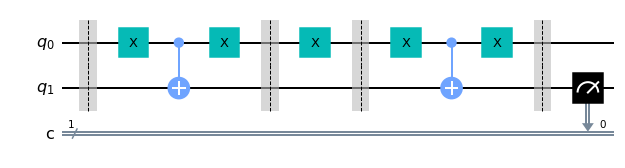

In [1]:
# Define functions
import numpy as np

from qiskit import *

cr=ClassicalRegister(1,'c')
qr=QuantumRegister(2,'q')
qc=QuantumCircuit(qr,cr)

#chose a function at random
k=np.random.randint(1,4)
if k==1:
    oracle = "constant"
elif k==2:
    oracle = "constant"        
elif k==3:
    oracle = "balanced"        
elif k==4:
    oracle = "balanced"
    
# Define Uf (Only Oracle knows it)
def Uf(k):
    
    # Uf appears between barriers
    qc.barrier([qr[0],qr[1]])
    
    if k==1:
        qc.i([qr[0],qr[1]])
        oracle = "constant"
    elif k==2:
        qc.x(qr[1])
        oracle = "constant"        
    elif k==3:
        qc.x(qr[0])
        qc.cx(qr[0],qr[1])
        qc.x(qr[0])
        oracle = "balanced"        
    elif k==4:
        qc.cx(qr[0],qr(1))
        oracle = "balanced"
        
    qc.barrier([qr[0],qr[1]])
    
    
# Consturct circuit

Uf(k)
qc.x(qr[0])
Uf(k)
qc.measure(qr[1],cr[0])
qc.draw('mpl')


In [2]:
# Chose a general quantum simulator without noise.
# The simulator behaves as an ideal quantum computer.
backend = Aer.get_backend('qasm_simulator')

# set number of tries
nshots=8192

# execute the quantum circuit and store the outcome
job = backend.run(qc,shots=nshots)

# extract the result
result = job.result()

# count the outcome
counts = result.get_counts()

# evaluate the probability
p0=counts.get('0',0)/nshots
p1=counts.get('1',0)/nshots

if p0 > p1:
    answer = "constant"
elif p0 < p1:
    answer = "balanced"
else:
    answer = "unknown"
       
print("Quantum computer has found that the function is",answer,".")

if oracle==answer:
    print("Correct! Oracle has",oracle,".")
else:
    print("Wrong! Oracle has",oracle,".")


Quantum computer has found that the function is balanced .
Correct! Oracle has balanced .


## The Deutsch's algorithm

Here is a challenge.  Can we solve the problem using $U_f$ only once? In the previous algorithm, we use $U_f$ twice, first for $x=0$ and second for $x=1$.  The key idea is that $y$ can be in a superposition state.  If $|y\rangle = |-\rangle$, what would be the answer from the oracle? 

Let us try to find how the oracle responds.

$$
U_f |x\rangle \otimes |-\rangle = |x \rangle \otimes \frac{1}{\sqrt{2}} \left( |f(x)\rangle - |1\oplus f(x)\rangle\right) = (-1)^{f(x)} |x\rangle \otimes |-\rangle
$$

Depending on the value of $f(x)$, the gate does nothing or changes the phase.  This trick is known as *phase kickback*.

Now, we replace $|x\rangle$ with another superposition state $|+\rangle$.

$$
U_f |+\rangle \otimes |-\rangle = \frac{1}{\sqrt{2}} \left [ (-1)^{f(0)} |0\rangle \otimes -\rangle + (-1)^{f(1)} | 1 \rangle \otimes |-\rangle \right ]
$$(Uf+-)

If the function is constant, $f(0)=f(1)$.  Then, Eq. {eq}`Uf+-` becomes

$$
U_f |+\rangle \otimes |-\rangle = (-1)^{f(0)} |+\rangle \otimes |-\rangle
$$(Uf+-constant)

In it is balanced, $f(0)\ne f(1)$, then we have

$$
U_f |+\rangle \otimes |-\rangle = \pm |-\rangle \otimes |-\rangle
$$(Uf+-balanced)

Apart from the global phase, the difference between Eqs. {eq}`Uf+-constant` and {eq}`Uf+-balanced` is the state of $q_0$.  If it is $+\rangle$, then the answer is constant. If it is $|-\rangle$ then, the answer is balanced.  Since we can measure only in the computational basis, we transofrm $\pm\rangle$ by a Hadamard gate.

Here is the summary of the Deustch's algorithm.

1. Prepare $|+\rangle \otimes |-\rangle$.
2. Apply $U_f$.
3. Apply $H \otimes I$
4. Measure $q_0$

We use $U_f$ only once!   Notice that we calculate $x=0$ and $x=1$ simultaneously using the super position state.

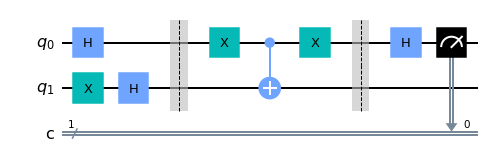

In [3]:
cr=ClassicalRegister(1,'c')
qr=QuantumRegister(2,'q')
qc=QuantumCircuit(qr,cr)

qc.x(qr[1])
qc.h([qr[0],qr[1]])
Uf(k)
qc.h(qr[0])
qc.measure(qr[0],cr[0])

qc.draw('mpl')

In [4]:
# Chose a general quantum simulator without noise.
# The simulator behaves as an ideal quantum computer.
backend = Aer.get_backend('qasm_simulator')

# set number of tries
nshots=8192

# execute the quantum circuit and store the outcome
job = backend.run(qc,shots=nshots)

# extract the result
result = job.result()

# count the outcome
counts = result.get_counts()

p0=counts.get('0',0)/nshots
p1=counts.get('1',0)/nshots

if p0 > p1:
    answer = "constant"
elif p0 < p1:
    answer = "balanced"
else:
    answer = "unknown"
       
print("The function is found to be",answer, "( oracle actually has",oracle,")")


The function is found to be balanced ( oracle actually has balanced )
